In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [4]:
df=pd.read_csv('jena_climate_2009_2016.csv')
df.index=pd.to_datetime(df['Date Time'],format='%d.%m.%Y %H:%M:%S')
df.columns
df.shape

(420551, 16)

In [7]:
df.columns

Index(['Unnamed: 0', 'Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)',
       'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)',
       'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)',
       'max. wv (m/s)', 'wd (deg)'],
      dtype='object')

In [11]:
df=df[['T (degC)']]
df=df[5::6]

In [12]:
temp_df = pd.DataFrame({'Temperature':df['T (degC)']})
temp_df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09
...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09
2016-12-31 20:10:00,-1.40,1.483215e+09
2016-12-31 21:10:00,-2.75,1.483219e+09


In [13]:
day = 60*60*24
year = 365.2425*day

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,1.230775e+09,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,1.230779e+09,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,1.230782e+09,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,1.230786e+09,0.965926,0.258819,0.012916,0.999917


In [16]:
temp_df.drop('Seconds',axis=1,inplace=True)
temp_df

,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...
2016-12-31 19:10:00,-0.98,-0.953717,0.300706,0.006900,0.999976
2016-12-31 20:10:00,-1.40,-0.843391,0.537300,0.007617,0.999971
2016-12-31 21:10:00,-2.75,-0.675590,0.737277,0.008334,0.999965


In [137]:
def df_to_X_y(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

X, y = df_to_X_y(temp_df)
X.shape, y.shape

((70085, 6, 5), (70085,))

In [138]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5085, 6, 5), (5085,))

In [143]:
X_train[0][0]

array([-8.05      ,  0.25881905,  0.96592583,  0.01004912,  0.99994951])

In [144]:
temp_training_mean = np.mean(X_train[:, :, 0])
temp_training_std = np.std(X_train[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

preprocess(X_train)
preprocess(X_val)
preprocess(X_test)

array([[[ 1.04009706e+00, -9.65925826e-01,  2.58819045e-01,
          5.22877889e-01, -8.52407598e-01],
        [ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
          5.20431780e-01, -8.53903251e-01],
        [ 5.37051663e-01, -7.16474371e-12,  1.00000000e+00,
          5.19819584e-01, -8.54276068e-01]],

       [[ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
  

In [145]:
X_train[:2][0]
y_train[:2][0]

array([-2.05339708,  0.25881905,  0.96592583,  0.01004912,  0.99994951])

## Data Load

In [146]:
from torch.utils.data import DataLoader,TensorDataset

train_dataset=TensorDataset(torch.tensor(X_train,dtype=torch.float),torch.tensor(y_train,dtype=torch.float))
val_dataset=TensorDataset(torch.tensor(X_val,dtype=torch.float32),torch.tensor(y_val,dtype=torch.float32))
test_dataset=TensorDataset(torch.tensor(X_test).float(),torch.tensor(y_test).float())

train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=False)
val_dataloader=DataLoader(val_dataset,batch_size=64,shuffle=False)

train_dataset.tensors[0].shape,val_dataset.tensors[0].shape,test_dataset.tensors[0].shape

(torch.Size([60000, 6, 5]), torch.Size([5000, 6, 5]), torch.Size([5085, 6, 5]))

## Model

In [211]:
from torchsummary import summary
import matplotlib.pyplot as  plt
import os
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device
class LSTM(nn.Module):
    def __init__(self,input_size,output_size,num_layers,hidden_size):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.output_size=output_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size,num_layers=self.num_layers)
        self.relu=nn.ReLU()
        self.fc1=nn.Linear(self.hidden_size,8)
        self.fc2=nn.Linear(8,self.output_size)

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device)  #shape (nu_lyers=1,1,64)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device)
        out,_=self.lstm(x,(h0,c0))
        # out = self.relu(out[:, -1, :])
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out[:,-1,:]

def rmse(predictions, targets):
    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    return rmse


<img src="LSTM.png" width="520" height="500">
<img src="LSTM2.png" width="520" height="500">
<img src="LSTM3.png" width=520" height="500">

+ You always have to give a three-dimensional array as an input to your LSTM network (refer to the above image). Where the first dimension represents the batch size, the second dimension represents the number of time-steps you are feeding a sequence. And the third dimension represents the number of units in one input sequence. For example, input shape looks like `(batch_size, time_steps, seq_len)`. Let's look at an example in Keras.


```python 
lstm=nn.LSTM(input_size=5,hidden_size=64,num_layers=1)
relu=nn.ReLU()
fc1=nn.Linear(hidden_size,8)
fc2=nn.Linear(8,1)
h0 = torch.zeros(1, input.size(1), hidden_size).to(input.device) 
c0 = torch.zeros(1, input.size(1), hidden_size).to(input.device)
out,_=lstm(input,(h0,c0))
print(f'LSTM  output shape: {out.shape}')
out=fc1(out)
print(f'fc1  output shape: {out.shape}')
out=relu(out)
print(f'Relu  output shape: {out.shape}')
out=fc2(out)
print(f'fc2  output shape: {out.shape}')

h0   shape: torch.Size([1, 6, 64])
c0   shape: torch.Size([1, 6, 64])
input   shape: torch.Size([32, 6, 5])
LSTM  output shape: torch.Size([32, 6, 64])
fc1  output shape: torch.Size([32, 6, 8])
Relu  output shape: torch.Size([32, 6, 8])
fc2  output shape: torch.Size([32, 6, 1])
```

+ Summary
    + The input of the LSTM is always is a 3D array. (batch_size, time_steps, seq_len).
    + The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument.
    + If return_sequence is False, the output is a 2D array. (batch_size, units)
    + If return_sequence is True, the output is a 3D array. batch_size, time_steps, units)

In [357]:
epochs=50
input_size = 5  #5 tane feature var
hidden_size = 64
num_layers = 2
output_size=1  #
lr=0.001
model = LSTM(input_size,output_size,num_layers,hidden_size)
model.to(device)

criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)


best_val_loss = float('inf')
train_pred_dict={}
val_pred_dict={}
for epoch in range(0,epochs) :

    model.train()
    loss_sum=0
    trainpred=[]
    trainact=[]
    for batch_idx,(input,target) in enumerate(train_dataloader):
        input=input.to(device)
        target=target.unsqueeze(1).to(device)
        pred=model(input)
        loss=criterion(pred,target)
        loss_sum+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainpred.append(np.array(pred.detach().flatten()))
        trainact.append(np.array(target.flatten()))
    train_pred_dict.update({epoch:[np.concatenate(trainpred),np.concatenate(trainact)]})
    score_pred =rmse(train_pred_dict[epoch][0],train_pred_dict[epoch][1])
    avg_train_loss=loss_sum/batch_idx


    model.eval()
    val_loss_sum=0
    valpred=[]
    valact=[]
    with torch.no_grad():
        for val_batch_idx,(val_input,val_target) in enumerate(val_dataloader):
            val_input=val_input.to(device)
            val_target=val_target.unsqueeze(1).to(device)
            val_pred=model(val_input)
            val_loss=criterion(val_pred,val_target)
            val_loss_sum+=val_loss.item()
            valpred.append(np.array(val_pred.flatten()))
            valact.append(np.array(val_target.flatten()))

        val_pred_dict.update({epoch:[np.concatenate(valpred),np.concatenate(valact)]})
        score_val =rmse(val_pred_dict[epoch][0],val_pred_dict[epoch][1])
        avg_loss_val=val_loss_sum/val_batch_idx

        if avg_loss_val < best_val_loss:
            best_model_train_predict=train_pred_dict[epoch][0]
            best_model_train_target=train_pred_dict[epoch][1]
            best_model_val_predict=val_pred_dict[epoch][0]
            best_model_val_target=val_pred_dict[epoch][1]


            checkpoint_dir='mul_bestmodel/'
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)

            torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
            best_val_loss = val_loss

        
    # if epoch%10 ==0 :
        # avg_loss=loss_sum/10
    print(f'{epoch} Train score {score_pred},train avg loss: {avg_train_loss},****** Val score : {score_val},val avg loss: {avg_loss_val}')

0 Train score 6.5817060470581055,train avg loss: 43.34434249815844,****** Val score : 2.528883695602417,val avg loss: 6.700593126125825
1 Train score 1.7124472856521606,train avg loss: 2.9351609926213578,****** Val score : 1.3872495889663696,val avg loss: 2.004157380033762
2 Train score 0.9501689672470093,train avg loss: 0.9041894596614731,****** Val score : 1.7313852310180664,val avg loss: 3.053912727496563
3 Train score 0.8827788829803467,train avg loss: 0.7805021881158667,****** Val score : 1.8586474657058716,val avg loss: 3.4888599587556643
4 Train score 0.8568316698074341,train avg loss: 0.735349051566872,****** Val score : 1.668387770652771,val avg loss: 2.817622633316578
5 Train score 0.8276795148849487,train avg loss: 0.6862246209841019,****** Val score : 1.5204318761825562,val avg loss: 2.3550358525453468
6 Train score 0.8120590448379517,train avg loss: 0.6605934152695705,****** Val score : 1.1054084300994873,val avg loss: 1.2625316358529604
7 Train score 0.8137162923812866,tr

In [250]:
train_results = pd.DataFrame(data={'Train Predictions':best_model_train_predict, 'Actuals':best_model_train_target})
train_results

,Train Predictions,Actuals
0,-4.494686,-9.17
1,-8.732391,-8.10
2,-9.601263,-7.66
3,-7.313061,-7.04
4,-5.185324,-7.41
...,...,...
59995,7.382015,9.88
59996,11.590164,13.53
59997,14.690028,15.43
59998,15.792787,15.54


In [223]:
with torch.no_grad():
    predicted=model(train_dataloader.dataset.tensors[0].to(device))

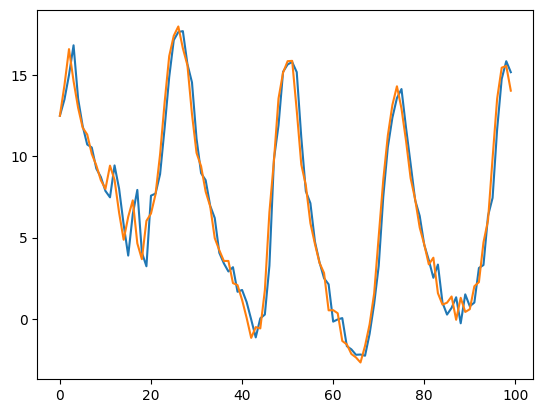

In [246]:
plt.plot(np.array(predicted.squeeze().detach())[-100:])
plt.plot(np.array(train_dataloader.dataset.tensors[1].squeeze())[-100:])

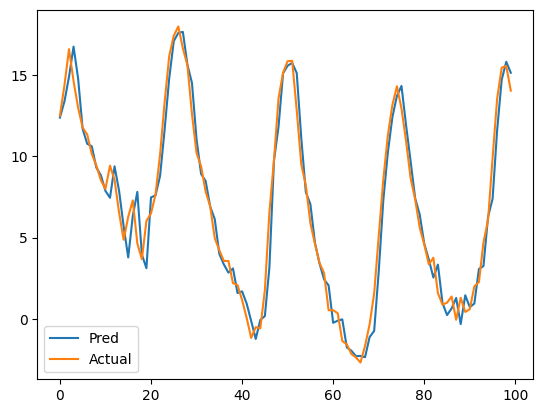

In [248]:
plt.plot(best_model_train_predict[-100:],label='Pred')
plt.plot(best_model_train_target[-100:],label='Actual')
plt.legend()

In [ ]:
plt.plot(best_model_val_predict[:60],label='Pred')
plt.plot(best_model_val_target[:60],label='Actual')
plt.legend()

In [251]:
checkpoint_dir

'mul_bestmodel/'

In [295]:
# Kaydedilmiş ağırlıkları yükleme
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_model.pth')))
X_train_tensor =train_dataset.tensors[0].cpu()
X_val_tensor =val_dataset.tensors[0].cpu()
X_test_tensor=test_dataset.tensors[0].cpu()
model.eval()  # Modeli değerlendirme moduna ayarlama
with torch.no_grad():  # Gradyan hesaplamalarını kapatma
    train_predictions_tensor = model(X_train_tensor)
    val_predictions_tensor = model(X_val_tensor)
    test_predictions_tensor = model(X_test_tensor)

train_predictions = train_predictions_tensor.cpu().numpy().flatten()  # NumPy array'e dönüştürme
val_predictions = val_predictions_tensor.cpu().numpy().flatten()  # NumPy array'e dönüştürme
test_predictions = test_predictions_tensor.cpu().numpy().flatten()  # NumPy array'e dönüştürme



print(train_results)

       Predictions  Actuals
0        -4.733530    -9.17
1        -9.053574    -8.10
2        -9.467088    -7.66
3        -6.957010    -7.04
4        -5.105871    -7.41
...            ...      ...
59995     7.442423     9.88
59996    11.647859    13.53
59997    14.736718    15.43
59998    15.827959    15.54
59999    15.155143    14.02

[60000 rows x 2 columns]


In [356]:
# Tahminleri ve gerçek değerleri bir DataFrame'e dönüştürme
train_results = pd.DataFrame(data={'Predictions': train_predictions, 'Actuals': y_train,'label':'train'})
val_results = pd.DataFrame(data={'Predictions': val_predictions, 'Actuals': y_val,'label':'validation'})
test_results = pd.DataFrame(data={'Predictions': test_predictions, 'Actuals': y_test,'label':'test'})
results_all=pd.concat([train_results,val_results,test_results],axis=0)

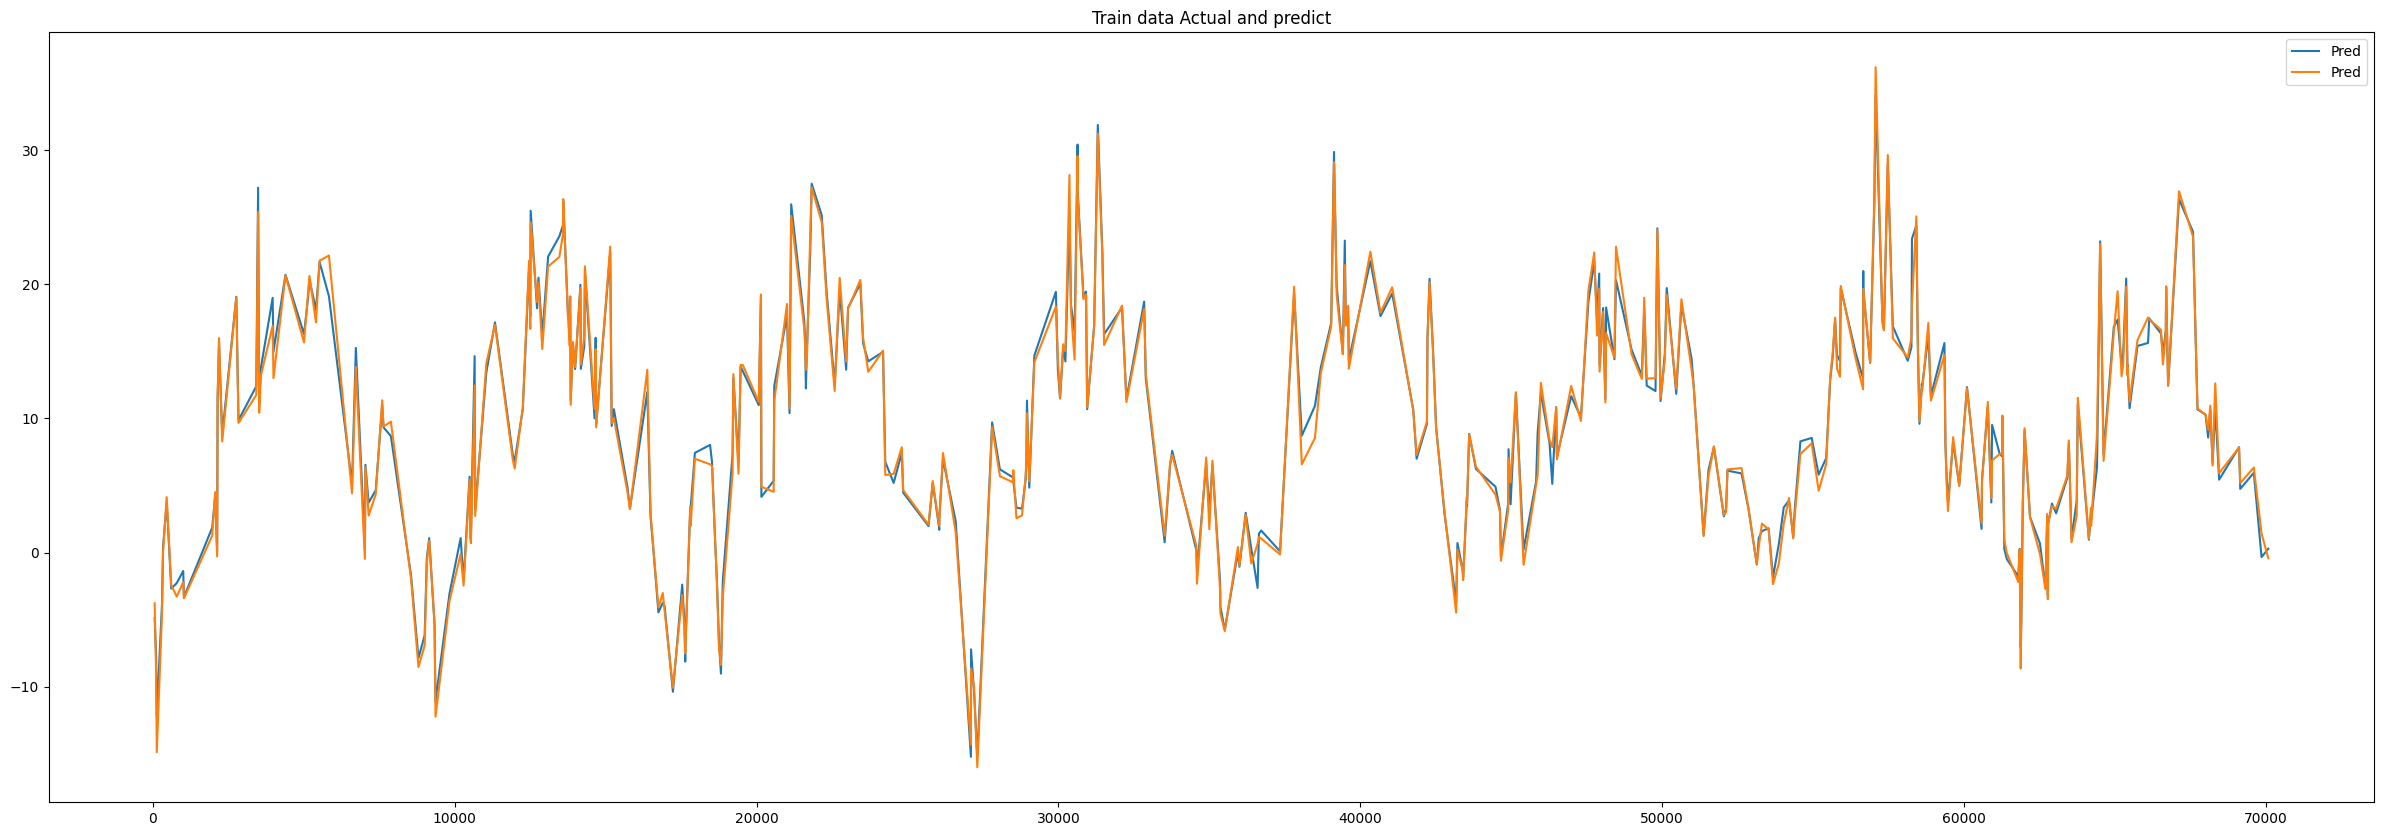

In [351]:
plt.figure(figsize=(30,10))
plt.title('Train data Actual and predict')
plt.plot(dum_result['Predictions'],label='Pred')
plt.plot(dum_result['Actuals'],label='Pred')
plt.legend()
plt.show()

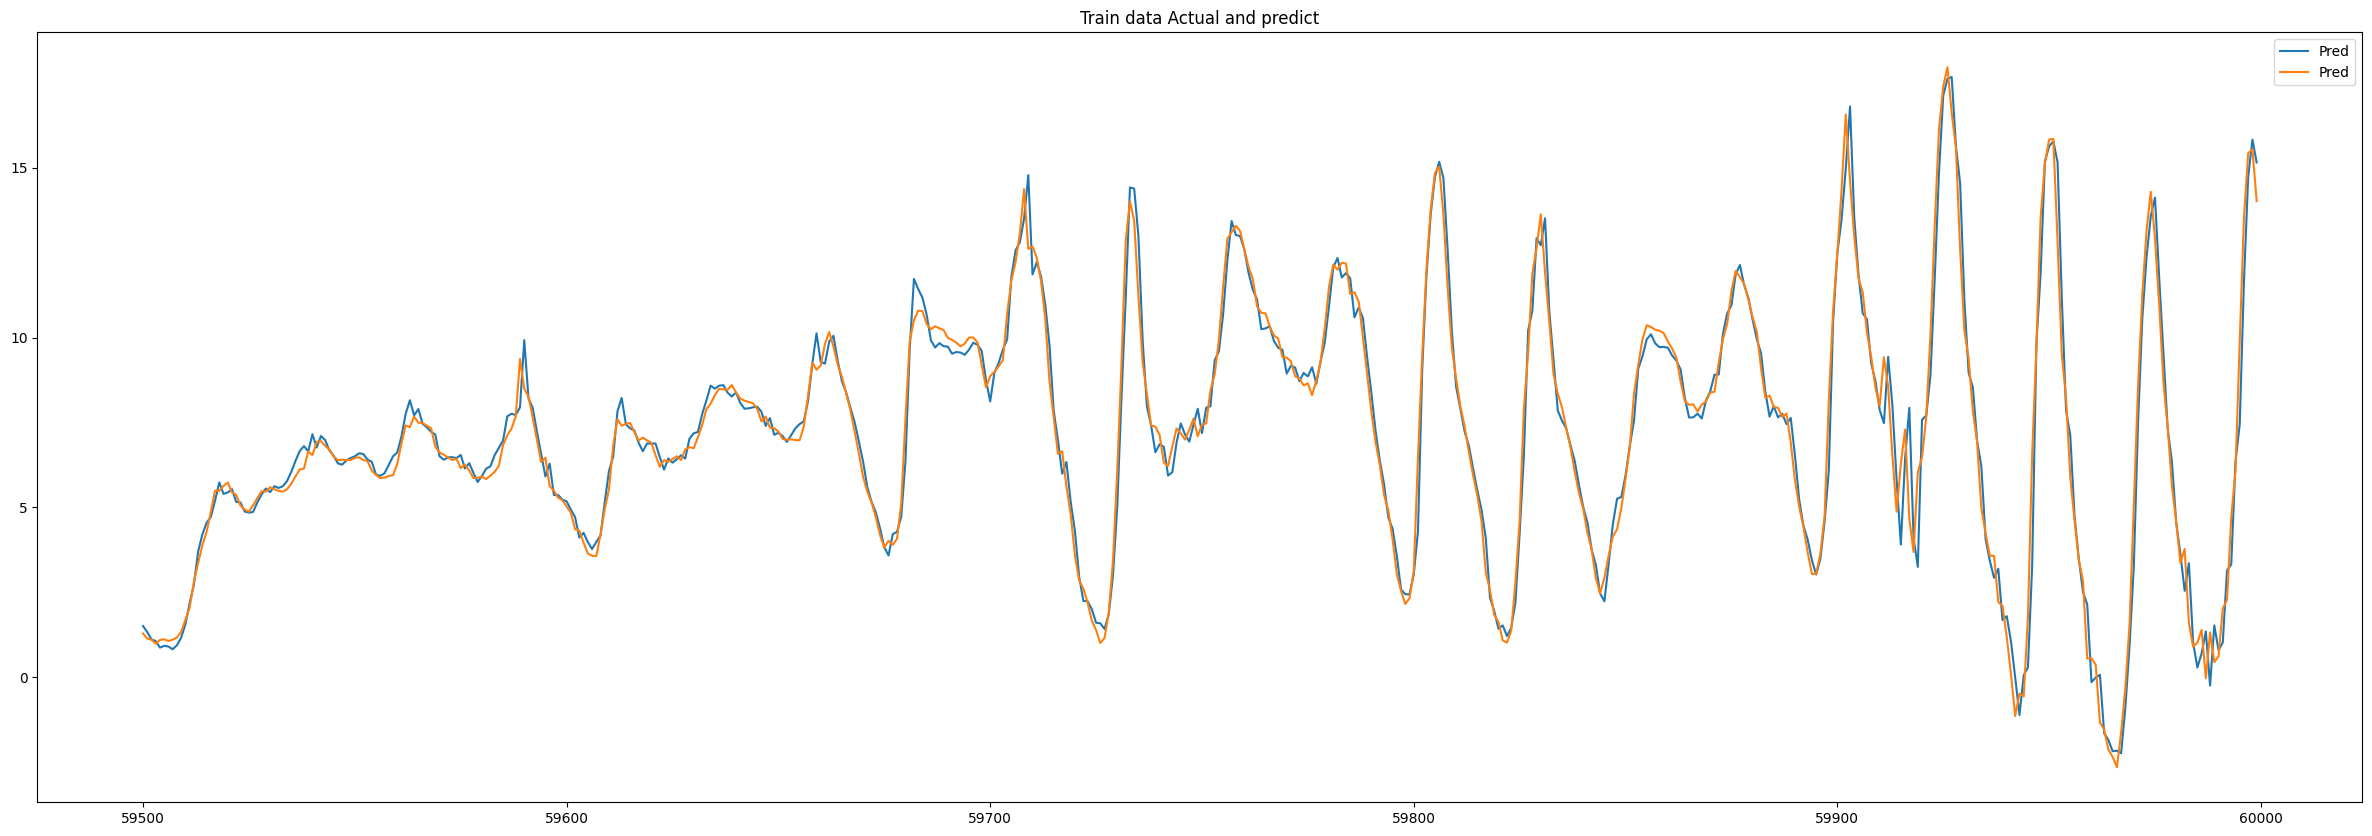

In [280]:
plt.figure(figsize=(30,10))
plt.title('Train data Actual and predict')
plt.plot(train_results['Train Predictions'][-500:],label='Pred')
plt.plot(train_results['Actuals'][-500:],label='Pred')
plt.legend()
plt.show()

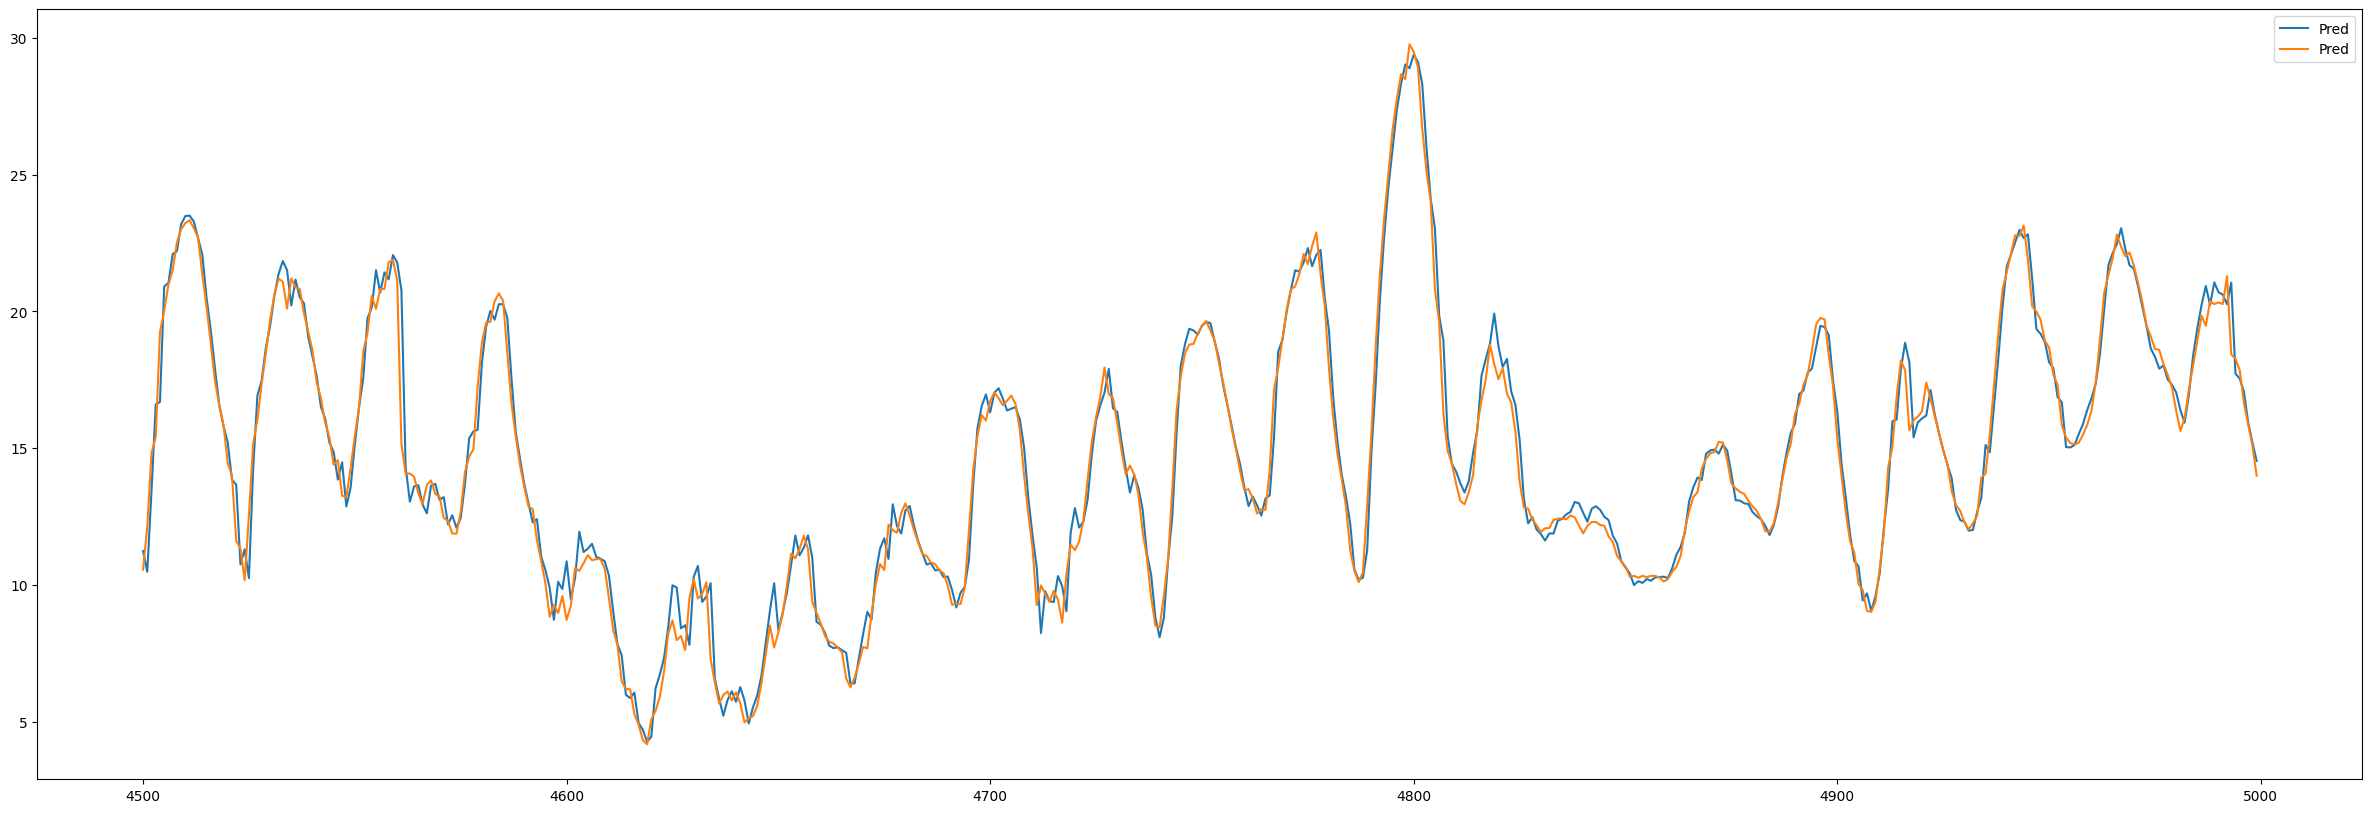

In [278]:
plt.figure(figsize=(30,10))
plt.title('Valdidation data Actual and predict')
plt.plot(val_results['Val Predictions'][-500:],label='Pred')
plt.plot(val_results['Actuals'][-500:],label='Pred')
plt.legend()
plt.show()

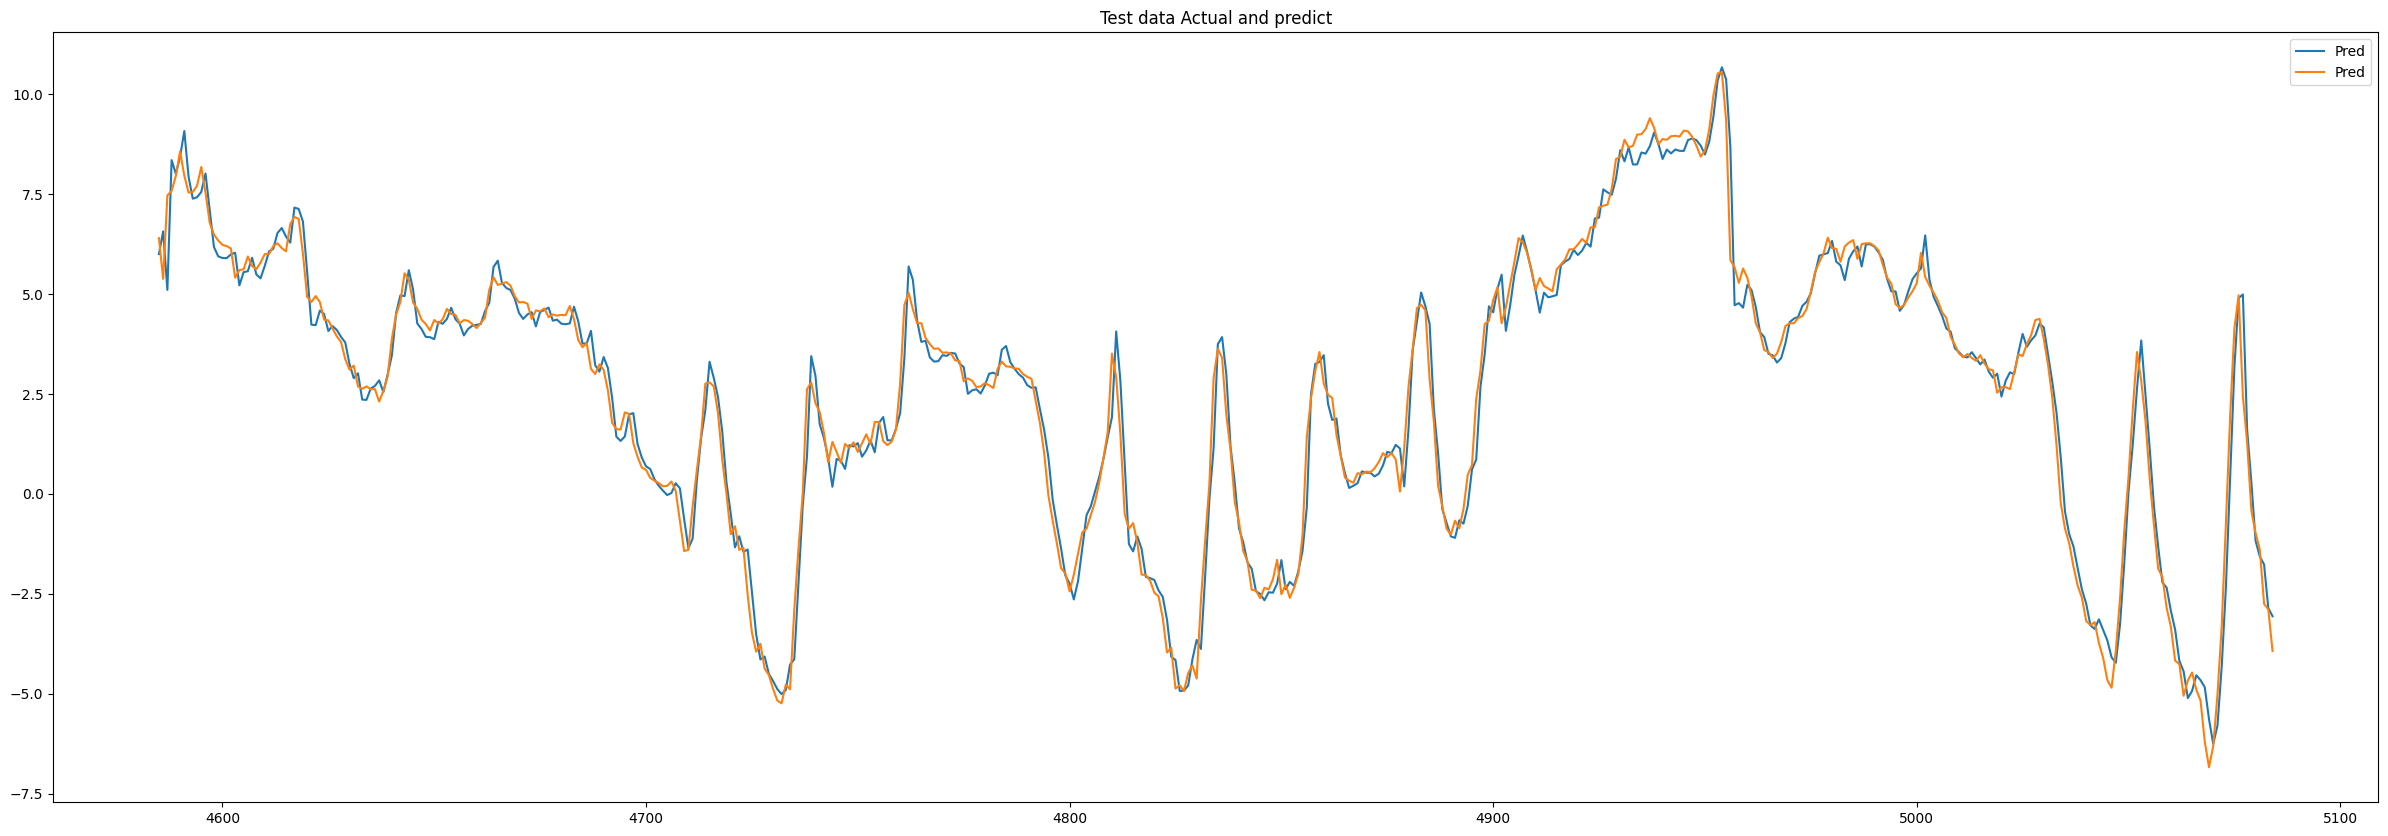

In [281]:
plt.figure(figsize=(30,10))
plt.title('Test data Actual and predict')
plt.plot(test_results['Test Predictions'][-500:],label='Pred')
plt.plot(test_results['Actuals'][-500:],label='Pred')
plt.legend()
plt.show()